<a href="https://colab.research.google.com/github/MariaShaiina/Marathon_DL_SSAU_2023/blob/main/Lab9/Lab9_Regularization_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




Шаина Мария гр. 6231-010402D

## **Лабораторная работа №9**



**Реализовать алгоритм обратного dropout для задачи классификации MNIST из предыдущего задания (для двух видов градиентного спуска):**

На этапе обучения сети (прямое распространение):

  1. генерируете случайную маску из нулей и единиц для слоя layer_1 с вероятностью p=0.5(можно использовать np.random.randint), либо найдите функцию для распределения Бернулли (биномиальное распределение)
  2. Умножаете выход слоя layer_1 на маску
  3. Умножаете  результат в пункте 2 на 1/(1-p)

  4. учесть применение слоя дропаут при обратном распространении сети


  На этапе тестирования сети:

  5. Обычное прямое распространение без dropout. Все как и раньше.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.utils import to_categorical

from scipy.stats import bernoulli

In [2]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [3]:
train_X.shape, test_X.shape

((60000, 28, 28), (10000, 28, 28))

Нормализуем данные

In [4]:
# Имеем картинки 28х28, на выходе получаем вектор из 784 значений (0,1)
X_train_vec = train_X.reshape((-1, 28*28)) / 255
X_test_vec = test_X.reshape((-1, 28*28)) / 255

In [5]:
X_train_vec.shape, X_test_vec.shape

((60000, 784), (10000, 784))

In [6]:
# кодируем метки классов (one-hot encoding)
print("Test Original Labels:", test_y, sep='\n')

test_y = to_categorical(test_y, num_classes=10)
train_y = to_categorical(train_y, num_classes=10)

print("\nTest One-Hot Encoded labels:", test_y, sep='\n')

Test Original Labels:
[7 2 1 ... 4 5 6]

Test One-Hot Encoded labels:
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
def relu(x):
    return (x > 0) * x # returns x if x > 0
                       # return 0 otherwise

def relu2deriv(output):
    return output>0 # returns 1 for input > 0
                    # return 0 otherwise

# Функция softmax для выходного слоя
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)


def model_prediction(input, weights_0_1, weights_1_2, dropout_mask, p):
  #forward pass
  layer_0 = input
  layer_1 = relu(np.dot(layer_0,weights_0_1))
  layer_1 *= dropout_mask  # applying dropout to layer_1
  layer_1 /= (1 - p)  # invert dropout during testing
  layer_2 = np.dot(layer_1,weights_1_2)
  return layer_0, layer_1, layer_2

СГС с DropOut

In [ ]:
np.random.seed(1)  # constant random values ​​during experimentation

p = 0.5 #узлы исключаются из сети с вероятностью 1-р, либо сохраняются с вероятностью р

# Создаем списки для хранения значений ошибки и точности на каждой итерации
train_accuracy_hist = []
train_error_hist = []
iteration_hist = []

# Определение гиперпараметров
learning_rate = 0.003
hidden_size = 40
input_size = X_train_vec.shape[1]  # 784
num_labels = train_y.shape[1]  # 10
iterations = 10

weights_0_1 = (2 * np.random.random((input_size, hidden_size)) - 1) / np.sqrt(input_size)  # веса между входным и скрытым слоями
weights_1_2 = (2 * np.random.random((hidden_size, num_labels)) - 1) / np.sqrt(hidden_size)  # веса между скрытым и выходным слоями

for iteration in range(iterations):
    error = 0
    for i in range(len(X_train_vec[:1000])): #обновление весов для каждого пример
        # forward pass
        layer_0 = X_train_vec[i:i + 1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))

        dropout_mask = np.zeros((layer_1.shape[0], layer_1.shape[1])) # add dropout mask, p=0,5
        dropout_count = 0

        for i in range(layer_1.shape[0]):
            for j in range(layer_1.shape[1]):
                if np.random.rand() < p:
                    dropout_mask[i][j] = 1
                    dropout_count += 1
                else:
                    dropout_mask[i][j] = 0

        dropout_mask = dropout_mask.astype(float)

        layer_1 *= dropout_mask  # applying dropout to layer_1
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((layer_2 - train_y[i:i + 1]) ** 2)

        # backward pass
        layer_2_delta = 2 * (layer_2 - train_y[i:i + 1])
        weight_1_2_corrections = layer_1.T.dot(layer_2_delta)  # величина коррекции для весов между layer_1 и layer_2

        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        weight_0_1_corrections = layer_0.T.dot(layer_1_delta)

        weights_1_2 -= learning_rate * weight_1_2_corrections
        weights_0_1 -= learning_rate * weight_0_1_corrections

    if (iteration % 2 != 0):
      train_error_hist.append(error)
      iteration_hist.append(iteration)
      goal_idx = np.argmax(train_y[:100], axis=1)
      y_pred = model_prediction(X_train_vec[:100], weights_0_1, weights_1_2, dropout_mask, p)
      pred_idx = np.argmax(y_pred, axis=1)
      acc = accuracy_score(goal_idx, pred_idx)
      train_accuracy_hist.append(acc)
      print(f"Iteration {iteration + 1} \nError: {str(error)} \nАcc: {str(acc)}")
      print()

print(dropout_count / (layer_1.shape[0]*layer_1.shape[1]))
print('\nDropout mask', dropout_mask)

Постройте графики функции потерь и accuracy на обучающей выборке

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 4.5), constrained_layout=True)

error_range = np.linspace(0.15, 0)

ax[0].set_title('Train Accuracy', size=14)
ax[0].set_xlabel('Epochs', size=12)
ax[0].set_ylabel('Accuracy', size=12)
ax[1].set_title('Train Error', size=14)
ax[1].set_xlabel('Epochs', size=12)
ax[1].set_ylabel('Error', size=12)

ax[0].plot(iteration_hist, train_accuracy_hist)
ax[1].plot(iteration_hist, train_error_hist)
ax[0].grid()
ax[1].grid()

Обучение стохастическим градиентным спуском по мини-батчам c применением DropOut

In [10]:
np.random.seed(1)

# Определение гиперпараметров
learning_rate=0.005 #скорость обучения
hidden_size = 128 #кол-во нейронов на скрытом слое
epochs=15 #число эпох
batch_size=32 #количество батчей
batch_n = len(train_y) // batch_size
p = 0.5

weights_0_1 = 2*np.random.random((784,hidden_size)) - 1 #веса между входным и скрытым слоями
weights_1_2 = 2*np.random.random((hidden_size,10)) - 1 #веса между скрытым и выходным слоями

# Создаем списки для хранения значений ошибки и точности на каждой итерации
test_error_hist = []
train_error_hist = []
train_accuracy_hist = []
test_accuracy_hist = []

# Обратное распространение ошибки
for epoch in range(epochs):
    # Перемешиваем данные
    indices = np.random.permutation(len(X_train_vec))
    X_train_shuffled = X_train_vec[indices]
    train_y_shuffled = train_y[indices]

    # SGD с мини-батчами
    for n in range(batch_n):
      # Forward pass
      input = X_train_shuffled[n*batch_size:n*batch_size + batch_size]
      target = train_y_shuffled[n*batch_size:n*batch_size + batch_size]

      # Forward pass
      layer_0 = input
      layer_1 = relu(np.dot(layer_0, weights_0_1))
      dropout_mask = np.zeros((layer_1.shape[0], layer_1.shape[1])) # add dropout mask, p=0,5
      dropout_count = 0

      for i in range(layer_1.shape[0]):
          for j in range(layer_1.shape[1]):
              if np.random.rand() < p:
                  dropout_mask[i][j] = 1
                  dropout_count += 1
              else:
                  dropout_mask[i][j] = 0

      dropout_mask = dropout_mask.astype(float)
      layer_1 *= dropout_mask  # applying dropout to layer_1
      layer_1 /= (1 - p)  # invert dropout during testing
      layer_2 = softmax(np.dot(layer_1, weights_1_2)) # vector of predictions for each sample

      # Backward pass
      layer_2_delta = layer_2 - target
      weight_1_2_corrections = np.dot(layer_1.T, layer_2_delta)

      layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
      weight_0_1_corrections = np.dot(layer_0.T, layer_1_delta)

      # Обновление весов
      weights_1_2 -= learning_rate * weight_1_2_corrections
      weights_0_1 -= learning_rate * weight_0_1_corrections

    #Тестирование на обучающем наборе данных
    train_layer_1 = relu(np.dot(X_train_vec, weights_0_1))
    train_output = softmax(np.dot(train_layer_1, weights_1_2))

    # Оценка точности на обучающем наборе
    train_predictions = np.argmax(train_output, axis=1)
    train_true_labels = np.argmax(train_y, axis=1)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)

    # Ошибка на обучающем наборе
    train_error = np.mean(-np.log(train_output[range(len(train_output)), np.argmax(train_y, axis=1)])) #cross-entropy
    train_error_hist.append(train_error)
    train_accuracy_hist.append(train_accuracy)

    # Тестирование на тестовом наборе данных
    test_layer_1 = relu(np.dot(X_test_vec, weights_0_1))
    test_output = softmax(np.dot(test_layer_1, weights_1_2))

    # Оценка точности на тестовом наборе
    test_predictions = np.argmax(test_output, axis=1)
    test_true_labels = np.argmax(test_y, axis=1)
    test_accuracy = accuracy_score(test_true_labels, test_predictions)

    # Ошибка на тестовом наборе
    test_error = np.mean(-np.log(test_output[range(len(test_output)), np.argmax(test_y, axis=1)]))
    test_error_hist.append(test_error)
    test_accuracy_hist.append(test_accuracy)

    # Вывод результатов
    print(f'Epoch {epoch + 1}/{epochs}, \nTrain Accuracy: {train_accuracy}, \nTest Accuracy: {test_accuracy}, \nTrain Error: {train_error}, \nTest Error: {test_error}')
    print()

Epoch 1/15, 
Train Accuracy: 0.87245, 
Test Accuracy: 0.8696, 
Train Error: 0.4304589844847245, 
Test Error: 0.4356864592932956

Epoch 2/15, 
Train Accuracy: 0.8962, 
Test Accuracy: 0.8942, 
Train Error: 0.34785898979037355, 
Test Error: 0.34816586254385035

Epoch 3/15, 
Train Accuracy: 0.91765, 
Test Accuracy: 0.915, 
Train Error: 0.2826409219313461, 
Test Error: 0.28995488598649505

Epoch 4/15, 
Train Accuracy: 0.9257166666666666, 
Test Accuracy: 0.9222, 
Train Error: 0.2549268640565517, 
Test Error: 0.26547308153929566

Epoch 5/15, 
Train Accuracy: 0.9298333333333333, 
Test Accuracy: 0.9274, 
Train Error: 0.23646656498021837, 
Test Error: 0.25491471138807664

Epoch 6/15, 
Train Accuracy: 0.9326833333333333, 
Test Accuracy: 0.9281, 
Train Error: 0.2227069827173151, 
Test Error: 0.2390045409895149

Epoch 7/15, 
Train Accuracy: 0.9356833333333333, 
Test Accuracy: 0.9305, 
Train Error: 0.2105942900603576, 
Test Error: 0.23078290331793877

Epoch 8/15, 
Train Accuracy: 0.94135, 
Test Accu

Постройте графики функции потерь и accuracy для двух выборок.

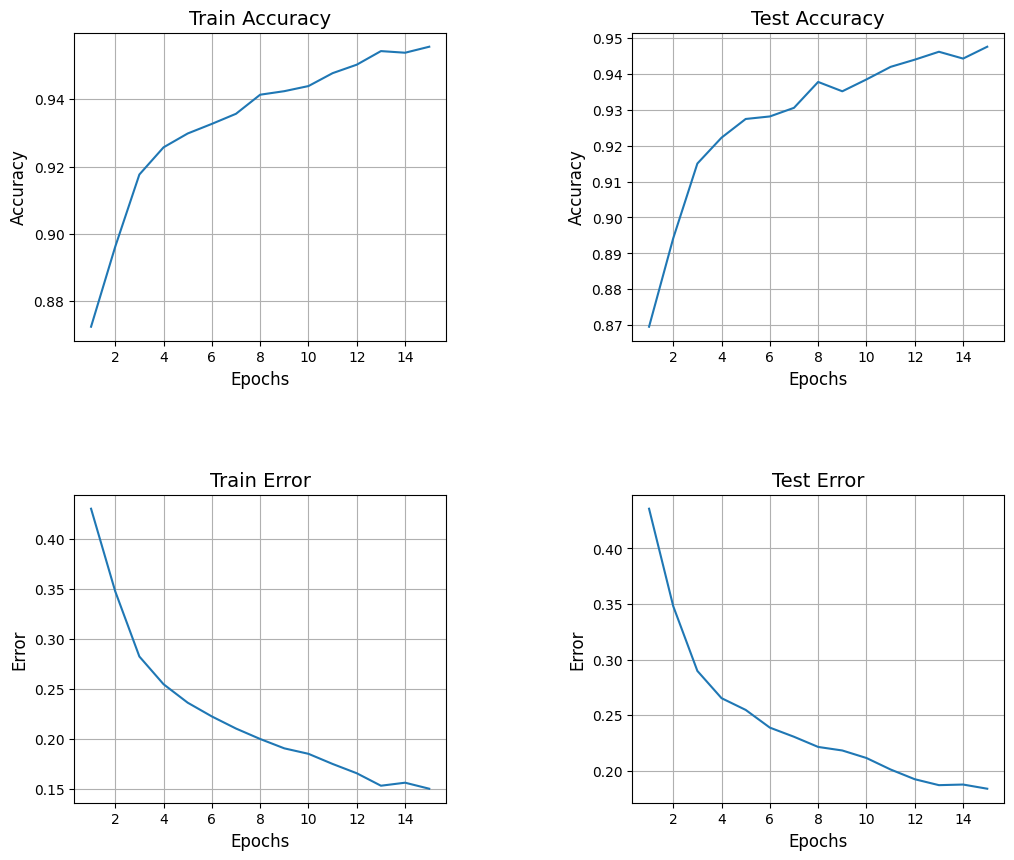

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12, 10))

plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax[0,0].set_title('Train Accuracy', size=14)
ax[0,0].set_xlabel('Epochs', size=12)
ax[0,0].set_ylabel('Accuracy', size=12)
ax[0,1].set_title('Test Accuracy', size=14)
ax[0,1].set_xlabel('Epochs', size=12)
ax[0,1].set_ylabel('Accuracy', size=12)
ax[1,0].set_title('Train Error', size=14)
ax[1,0].set_xlabel('Epochs', size=12)
ax[1,0].set_ylabel('Error', size=12)
ax[1,1].set_title('Test Error', size=14)
ax[1,1].set_xlabel('Epochs', size=12)
ax[1,1].set_ylabel('Error', size=12)

ax[0,0].plot(range(1, epochs+1), train_accuracy_hist)
ax[0,1].plot(range(1, epochs+1), test_accuracy_hist)
ax[1,0].plot(range(1, epochs+1), train_error_hist)
ax[1,1].plot(range(1, epochs+1), test_error_hist)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

Можно ли поставить слой дропаут после выходного слоя?

In [12]:
def ddropout_mask(h, w):
  dropout_mask = np.zeros((h, w))
  dropout_count = 0

  for i in range(h):
      for j in range(w):
          if np.random.rand() < p:
              dropout_mask[i][j] = 1
              dropout_count += 1
          else:
              dropout_mask[i][j] = 0

  dropout_mask = dropout_mask.astype(float)
  return dropout_mask, dropout_count

In [15]:
# Обратное распространение ошибки
for epoch in range(epochs):
    # Перемешиваем данные
    indices = np.random.permutation(len(X_train_vec))
    X_train_shuffled = X_train_vec[indices]
    train_y_shuffled = train_y[indices]

    # SGD с мини-батчами
    for n in range(batch_n):
      # Forward pass
      input = X_train_shuffled[n*batch_size:n*batch_size + batch_size]
      target = train_y_shuffled[n*batch_size:n*batch_size + batch_size]

      # Forward pass
      layer_0 = input
      layer_1 = relu(np.dot(layer_0, weights_0_1))
      dropout_mask, dropout_count = ddropout_mask(layer_1.shape[0], layer_1.shape[1])

      layer_1 *= dropout_mask  # applying dropout to layer_1
      layer_1 /= (1 - p)  # invert dropout during testing
      layer_2 = softmax(np.dot(layer_1, weights_1_2)) # vector of predictions for each sample

      # Backward pass
      dropout_mask, dropout_count = ddropout_mask(layer_2.shape[0], layer_2.shape[1])
      layer_2 *= dropout_mask  # applying dropout to layer_2
      layer_2 /= (1 - p)  # invert dropout during testing
      layer_2_delta = layer_2 - target
      weight_1_2_corrections = np.dot(layer_1.T, layer_2_delta)

      layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
      weight_0_1_corrections = np.dot(layer_0.T, layer_1_delta)

      # Обновление весов
      weights_1_2 -= learning_rate * weight_1_2_corrections
      weights_0_1 -= learning_rate * weight_0_1_corrections

    #Тестирование на обучающем наборе данных
    train_layer_1 = relu(np.dot(X_train_vec, weights_0_1))
    train_output = softmax(np.dot(train_layer_1, weights_1_2))

    # Оценка точности на обучающем наборе
    train_predictions = np.argmax(train_output, axis=1)
    train_true_labels = np.argmax(train_y, axis=1)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)

    # Ошибка на обучающем наборе
    train_error = np.mean(-np.log(train_output[range(len(train_output)), np.argmax(train_y, axis=1)])) #cross-entropy
    train_error_hist.append(train_error)
    train_accuracy_hist.append(train_accuracy)

    # Тестирование на тестовом наборе данных
    test_layer_1 = relu(np.dot(X_test_vec, weights_0_1))
    test_output = softmax(np.dot(test_layer_1, weights_1_2))

    # Оценка точности на тестовом наборе
    test_predictions = np.argmax(test_output, axis=1)
    test_true_labels = np.argmax(test_y, axis=1)
    test_accuracy = accuracy_score(test_true_labels, test_predictions)

    # Ошибка на тестовом наборе
    test_error = np.mean(-np.log(test_output[range(len(test_output)), np.argmax(test_y, axis=1)]))
    test_error_hist.append(test_error)
    test_accuracy_hist.append(test_accuracy)

    # Вывод результатов
    print(f'Epoch {epoch + 1}/{epochs}, \nTrain Accuracy: {train_accuracy}, \nTest Accuracy: {test_accuracy}, \nTrain Error: {train_error}, \nTest Error: {test_error}')
    print()

Epoch 1/15, 
Train Accuracy: 0.9008, 
Test Accuracy: 0.8961, 
Train Error: 0.3492553923400852, 
Test Error: 0.3752225459343767

Epoch 2/15, 
Train Accuracy: 0.8941333333333333, 
Test Accuracy: 0.8929, 
Train Error: 0.6170097435799574, 
Test Error: 0.5942615492983426

Epoch 3/15, 
Train Accuracy: 0.8821666666666667, 
Test Accuracy: 0.8772, 
Train Error: 0.5006558193183847, 
Test Error: 0.5384123325771341

Epoch 4/15, 
Train Accuracy: 0.8807333333333334, 
Test Accuracy: 0.8731, 
Train Error: 0.41666919225616555, 
Test Error: 0.44546393423783376

Epoch 5/15, 
Train Accuracy: 0.87835, 
Test Accuracy: 0.879, 
Train Error: 0.4608112085471736, 
Test Error: 0.48523241068667755

Epoch 6/15, 
Train Accuracy: 0.8831666666666667, 
Test Accuracy: 0.8796, 
Train Error: 0.5344259730408888, 
Test Error: 0.5504742082393994

Epoch 7/15, 
Train Accuracy: 0.8853, 
Test Accuracy: 0.8783, 
Train Error: 0.5312857997491397, 
Test Error: 0.5834732499729977

Epoch 8/15, 
Train Accuracy: 0.8727666666666667, 
Tes

Из результатов видно, что использование данной "модификации" приводит к снижению точности.

Дропаут обычно применяется только к скрытым слоям сети в процессе обучения. Применение dropout после выходного слоя вряд ли будет иметь смысл, так как выходной слой в основном отвечает за предсказания и уже имеет "встроенное" снижение переобучения за счет общего ограничения модели и использования функции потерь (например, кросс-энтропии).

В нашем примере с датасетом mnist, дропаут зануляет метки класса на выходе с вероятностью р=0.5. Таким образом, модель обучается только на одной части данных.